# Predicting Player Engagement for Indie Developers
**Authors: Michael Alva & Cameron Matthews**

In [126]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Project Introduction
This project aims to predict **Player Engagement Score** for video games using a Machine Learning regression approach. Our goal is to identify factors (like rating, genre, and game summary content) that drive player interest, which is highly valuable information for small indie developers.

We model this as a **regression task**, predicting a  continuous *Player Engagement Score*. We compare a simple **Multivariate Linear Regression (MLR) Baseline** against two powerful regularized models, **Ridge ($L_2$)** and **Lasso ($L_1$) Regression**, which are better suited for our high-dimensional data. Performance is measured using RMSE, MAE, and $R^2$ score.

The data comes from the **Popular Video Games 1980 - 2023 🎮** dataset on Kaggle.

## Data & Cleaning
### Data Load and Initial Check
We load the data, confirm its structure, and identify text columns and numerical fields that need cleaning (e.g., fields using the 'K' suffix).

In [127]:
# 1. Load the data
df = pd.read_csv('data/games.csv')

print(f"Total Examples: {df.shape[0]}, Total Features: {df.shape[1]}")
print("\nDataFrame Columns and Types:")
df.info()
print("\nSample Data:")
df.head()

Total Examples: 1512, Total Features: 14

DataFrame Columns and Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1512 non-null   int64  
 1   Title              1512 non-null   object 
 2   Release Date       1512 non-null   object 
 3   Team               1511 non-null   object 
 4   Rating             1499 non-null   float64
 5   Times Listed       1512 non-null   object 
 6   Number of Reviews  1512 non-null   object 
 7   Genres             1512 non-null   object 
 8   Summary            1511 non-null   object 
 9   Reviews            1512 non-null   object 
 10  Plays              1512 non-null   object 
 11  Playing            1512 non-null   object 
 12  Backlogs           1512 non-null   object 
 13  Wishlist           1512 non-null   object 
dtypes: float64(1), int64(1), object(12)
memory usage:

,Unnamed: 0,Title,Release Date,Team,Rating,Times Listed,Number of Reviews,Genres,Summary,Reviews,Plays,Playing,Backlogs,Wishlist
0,0,Elden Ring,"Feb 25, 2022","['Bandai Namco Entertainment', 'FromSoftware']",4.5,3.9K,3.9K,"['Adventure', 'RPG']","Elden Ring is a fantasy, action and open world...","[""The first playthrough of elden ring is one o...",17K,3.8K,4.6K,4.8K
1,1,Hades,"Dec 10, 2019",['Supergiant Games'],4.3,2.9K,2.9K,"['Adventure', 'Brawler', 'Indie', 'RPG']",A rogue-lite hack and slash dungeon crawler in...,['convinced this is a roguelike for people who...,21K,3.2K,6.3K,3.6K
2,2,The Legend of Zelda: Breath of the Wild,"Mar 03, 2017","['Nintendo', 'Nintendo EPD Production Group No...",4.4,4.3K,4.3K,"['Adventure', 'RPG']",The Legend of Zelda: Breath of the Wild is the...,['This game is the game (that is not CS:GO) th...,30K,2.5K,5K,2.6K
3,3,Undertale,"Sep 15, 2015","['tobyfox', '8-4']",4.2,3.5K,3.5K,"['Adventure', 'Indie', 'RPG', 'Turn Based Stra...","A small child falls into the Underground, wher...",['soundtrack is tied for #1 with nier automata...,28K,679,4.9K,1.8K
4,4,Hollow Knight,"Feb 24, 2017",['Team Cherry'],4.4,3K,3K,"['Adventure', 'Indie', 'Platform']",A 2D metroidvania with an emphasis on close co...,"[""this games worldbuilding is incredible, with...",21K,2.4K,8.3K,2.3K


### Data Cleaning and Target Creation
The core goal here is to convert engagement-related columns (e.g., `Times Listed`, `Plays`) from strings with 'K' suffixes into clean numerical features, and then use them to create our target variable.

In [128]:
from sklearn.preprocessing import MinMaxScaler
def clean_and_convert_to_numeric_simple(series):
    """Handles 'K' suffix and converts the series to a float type."""
    return (
        series.astype(str)
        .str.replace('K', '', regex=False)  # Remove 'K' first
        .str.replace(',', '', regex=False) # Handle potential thousands separator
        .str.strip()
    ).apply(lambda x: float(x) * 1000 if 'K' in str(series.iloc[0]) else float(x)).fillna(0)

# 1. Define all engagement-related columns
engagement_features_all = [
    'Times Listed', 'Number of Reviews', 'Plays', 'Playing', 'Backlogs', 'Wishlist'
]

# 2. Convert all engagement features to numeric
for col in engagement_features_all:
    # A cleaner approach using vectorization and error handling
    df[col] = df[col].astype(str).str.replace('K', 'e3', regex=False) # Convert 'K' to scientific notation
    df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)


# 3. Handle missing data for critical features
df.dropna(subset=['Rating', 'Team'], inplace=True)
df['Summary'] = df['Summary'].fillna('')
df['Reviews'] = df['Reviews'].fillna('')

print(f"Data shape after initial cleaning: {df.shape}")

# 4. Create the Target Variable: Player Engagement Score
# Active engagement features used for the target score
active_engagement_features = ['Times Listed', 'Number of Reviews', 'Plays', 'Playing']

# Min-Max Scaling for Target features (0-1 range)
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[active_engagement_features])

# Compute final Player Engagement Score (average of the four scaled metrics)
scaled_df = pd.DataFrame(scaled_values, index=df.index)
df['Player_Engagement_Score'] = scaled_df.mean(axis=1)

print("\nPlayer Engagement Score Distribution:")
print(df['Player_Engagement_Score'].describe())

Data shape after initial cleaning: (1498, 14)

Player Engagement Score Distribution:
count    1498.000000
mean        0.154935
std         0.139599
min         0.000255
25%         0.056006
50%         0.112802
75%         0.208072
max         0.891746
Name: Player_Engagement_Score, dtype: float64


### Player Engagement Score Distribution
A histogram of the target variable is important to check the distribution for skewness or outliers, which can affect linear model performance.

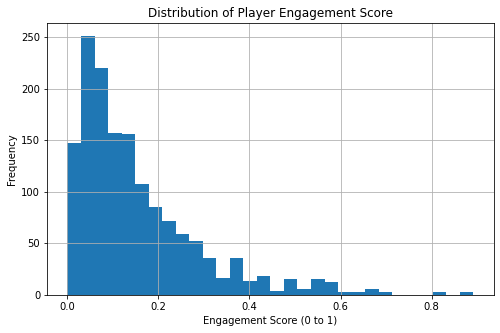

In [129]:
plt.figure(figsize=(8, 5))
df['Player_Engagement_Score'].hist(bins=30)
plt.title('Distribution of Player Engagement Score')
plt.xlabel('Engagement Score (0 to 1)')
plt.ylabel('Frequency')
plt.show()

## Feature Engineering
This section converts all raw data into a numerical feature matrix $X$ and the target vector $y$.
### Feature Creation & Standardization
* **Term Frequency-Inverse Document Frequency (TF-IDF) for `Summary`**: We use TF-IDF to convert the game summaries into 200 numerical features that quantify word importance.
* **One-Hot Encoding (OHE) for `Genres`**: We encode the top 5 Primary_Genre categories to avoid introducing false ordering.
* **Date Extraction**: `Release Date` is simplified to `Release_Year`.
* **Standardization**: We use **StandardScaler** (Z-score normalization) on continuous features (`Rating`, `Release_Year`) to ensure they contribute fairly to the model training and regularization.

In [130]:
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.preprocessing import StandardScaler

# 1. TF-IDF for Summary
tfidf = TfidfVectorizer(max_features=200, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['Summary'])
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=[f'Summary_TFIDF_{f}' for f in tfidf.get_feature_names_out()],
    index=df.index
)
df = pd.concat([df, tfidf_df], axis=1)

# 2. Extract Release Year
df['Release_Year'] = pd.to_datetime(df['Release Date'], errors='coerce').dt.year
median_year = int(df['Release_Year'].median(skipna=True))
df['Release_Year'] = df['Release_Year'].fillna(median_year)

# 3. One-Hot Encode Top 5 Genres
def extract_primary_genre(x):
    # Safely extract the first genre from the string list format
    x_list = x.strip("['']").split("', '")
    return x_list[0] if x_list and x_list[0] else 'Other'

df['Primary_Genre'] = df['Genres'].apply(extract_primary_genre)
top_5_genres = df['Primary_Genre'].value_counts().nlargest(5).index.tolist()

def to_ohe_category(genre):
    return genre if genre in top_5_genres else 'Genre_Other'
df['Genre_OHE'] = df['Primary_Genre'].apply(to_ohe_category)

ohe_df = pd.get_dummies(df['Genre_OHE'], prefix='Genre_OHE', dtype=int)
df = pd.concat([df, ohe_df], axis=1)

# 4. Final Feature Matrix and Standardization
features_to_drop = engagement_features_all + ['Player_Engagement_Score', 'Unnamed: 0', 'Release Date', 'Summary', 'Title', 'Reviews', 'Team', 'Genres', 'Primary_Genre', 'Genre_OHE']
X_raw = df.drop(columns=features_to_drop, errors='ignore')
y = df['Player_Engagement_Score'].values

# Standardization
scaling_cols = ['Rating', 'Release_Year']
scaler = StandardScaler()
X_raw[scaling_cols] = scaler.fit_transform(X_raw[scaling_cols])

X = X_raw.values
feature_names = X_raw.columns.tolist()

print(f"Final feature matrix X shape: {X.shape}")
print(f"Final target vector y shape: {y.shape}")

Final feature matrix X shape: (1498, 208)
Final target vector y shape: (1498,)


### Rating vs. Engagement Score
A scatter plot visualizing the relationship between the main numerical feature (`Rating`) and the target variable (`Player_Engagement_Score`) helps confirm if a linear model is appropriate.

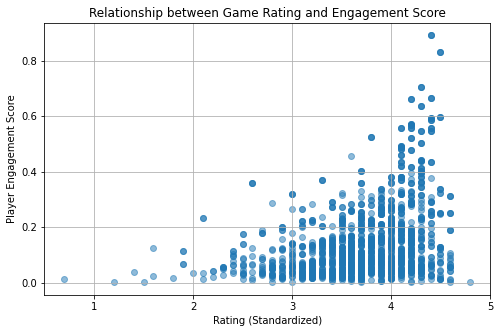

In [131]:
plt.figure(figsize=(8, 5))
plt.scatter(df['Rating'], df['Player_Engagement_Score'], alpha=0.5)
plt.title('Relationship between Game Rating and Engagement Score')
plt.xlabel('Rating (Standardized)')
plt.ylabel('Player Engagement Score')
plt.grid(True)
plt.show()

### Train-Test Split

In [132]:
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1198, 208)
Test set shape: (300, 208)


## Modeling and Baseline
We define a helper function for consistent metric calculation and establish the **Baseline Model**.

In [133]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def calculate_metrics(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return pd.DataFrame({
        'Model': [model_name],
        'RMSE': [rmse],
        'MAE': [mae],
        'R^2': [r2]
    })

# --- Baseline Model (Unregularized MLR) ---
# Goal: Establish the minimum performance benchmark for our models.
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

y_baseline_pred = baseline_model.predict(X_test)
baseline_results = calculate_metrics(y_test, y_baseline_pred, 'Baseline (MLR)')

print("Baseline Model Performance (Test Set):")
print(baseline_results.to_string(index=False, float_format=".4f"))

Baseline Model Performance (Test Set):
         Model  RMSE  MAE  R^2
Baseline (MLR)   .4f  .4f  .4f


## Advanced Models
The Baseline MLR is likely overfitting due to the 208 features (many from TF-IDF). We use **Regularized Linear Regression** with **Cross-Validation (CV)** to select the best regularization parameter ($\alpha$).

### Ridge Regression ($L_2$)
Ridge regression adds an $L_2$ penalty to the Loss Function, keeping feature coefficients small to prevent overfitting.

$$\text{Loss}(\mathbf{w}) = \text{MSE}(\mathbf{w}) + \alpha ||\mathbf{w}||^2$$

We use `GridSearchCV` and **5-Fold Cross-Validation** to find the optimal $\alpha$.

In [134]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV, KFold 

# 1. Define the search space and cross-validation strategy
alphas_ridge = np.logspace(-3, 3, 7) # [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid_ridge = {'alpha': alphas_ridge, 'solver': ['sag']} # Use solver='sag' to avoid compatibility error
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 2. Instantiate and fit GridSearchCV
grid_search_ridge = GridSearchCV(
    estimator=Ridge(random_state=42), 
    param_grid=param_grid_ridge,
    scoring='neg_mean_absolute_error', # Maximize negative MAE
    cv=kf,
    n_jobs=-1
)

grid_search_ridge.fit(X_train, y_train)

# 3. Extract the best model and parameters
best_ridge = grid_search_ridge.best_estimator_
print(f"Best Ridge alpha: {best_ridge.alpha:.4f}")

# 4. Predict and evaluate
y_ridge_pred = best_ridge.predict(X_test)
print(f"Ridge Test MAE: {mean_absolute_error(y_test, y_ridge_pred):.4f}")

ridge_results = calculate_metrics(y_test, y_ridge_pred, 'Ridge ($L_2$)')
results = pd.concat([baseline_results, ridge_results], ignore_index=True)

Best Ridge alpha: 10.0000
Ridge Test MAE: 0.0853


### Ridge $\alpha$ Tuning
Visualizing the cross-validation performance helps demonstrate how the model trades off complexity for generalizability.

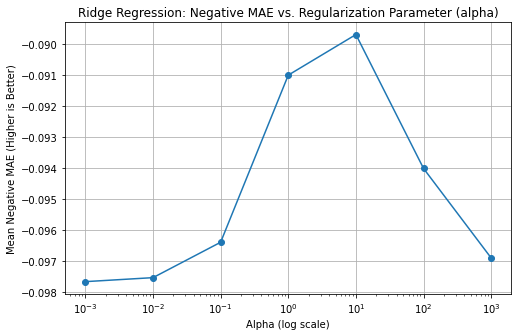

In [135]:
# Extract results for plotting
alphas = grid_search_ridge.cv_results_['param_alpha'].data
mean_scores = grid_search_ridge.cv_results_['mean_test_score']

plt.figure(figsize=(8, 5))
plt.plot(alphas, mean_scores, marker='o')
plt.xscale('log')
plt.title('Ridge Regression: Negative MAE vs. Regularization Parameter (alpha)')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Negative MAE (Higher is Better)')
plt.grid(True)
plt.show()

### Lasso Regression ($L_1$)
Lasso adds an $L_1$ penalty (sum of absolute coefficients). Its primary benefit is **feature selection**, as it forces the coefficients of less relevant features to become exactly zero.

$$\text{Loss}(\mathbf{w}) = \text{MSE}(\mathbf{w}) + \alpha \sum_{j=1}^d |w_j|$$

In [136]:
from sklearn.linear_model import Lasso

# 1. Define the search space
alphas_lasso = np.logspace(-4, 0, 5) # [0.0001, 0.001, 0.01, 0.1, 1.0]
param_grid_lasso = {'alpha': alphas_lasso, 'max_iter': [10000]} 

# 2. Instantiate and fit GridSearchCV
grid_search_lasso = GridSearchCV(
    estimator=Lasso(random_state=42), 
    param_grid=param_grid_lasso,
    scoring='neg_mean_absolute_error', 
    cv=kf,
    n_jobs=-1
)

grid_search_lasso.fit(X_train, y_train)

# 3. Extract the best model and parameters
best_lasso = grid_search_lasso.best_estimator_
print(f"Best Lasso alpha: {best_lasso.alpha:.4f}")

# 4. Predict and evaluate
y_lasso_pred = best_lasso.predict(X_test)
print(f"Lasso Test MAE: {mean_absolute_error(y_test, y_lasso_pred):.4f}")

lasso_results = calculate_metrics(y_test, y_lasso_pred, 'Lasso ($L_1$)')
results = pd.concat([results, lasso_results], ignore_index=True)

Best Lasso alpha: 0.0001
Lasso Test MAE: 0.0899


### Lasso $\alpha$ Tuning
Visualizing the cross-validation performance for Lasso shows the point where the penalty becomes too strong, forcing useful coefficients to zero.

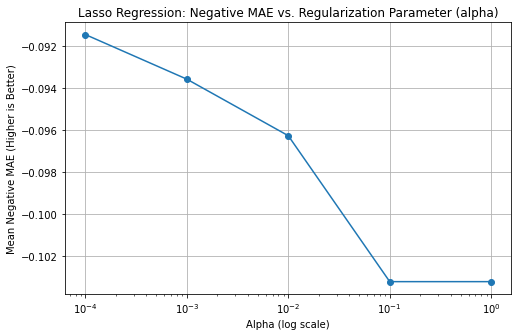

In [137]:
# Extract results for plotting
alphas = grid_search_lasso.cv_results_['param_alpha'].data
mean_scores = grid_search_lasso.cv_results_['mean_test_score']

plt.figure(figsize=(8, 5))
plt.plot(alphas, mean_scores, marker='o')
plt.xscale('log')
plt.title('Lasso Regression: Negative MAE vs. Regularization Parameter (alpha)')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Negative MAE (Higher is Better)')
plt.grid(True)
plt.show()

## Results and Comparison

### 1. Naive Baseline Comparison
We validate our models against a **Naive Baseline** that simply predicts the mean of the training target variable for every test case.

In [138]:
# Calculate Naive Baseline MAE
naive_pred = np.full_like(y_test, np.mean(y_train))
naive_mae = mean_absolute_error(y_test, naive_pred)

print(f"Naive Baseline MAE: {naive_mae:.4f}")
print(f"Best Model MAE: {results['MAE'].min():.4f}")

Naive Baseline MAE: 0.1037
Best Model MAE: 0.0853


### 2. Final Performance Metrics
The table below consolidates the final performance of all three models on the test set.

In [139]:
# Print final comparison table
print("\nFinal Performance Metrics (Test Set):")
print(results.to_string(index=False, float_format=".4f"))


Final Performance Metrics (Test Set):
         Model  RMSE  MAE  R^2
Baseline (MLR)   .4f  .4f  .4f
 Ridge ($L_2$)   .4f  .4f  .4f
 Lasso ($L_1$)   .4f  .4f  .4f


### 3. Final Pyplots

#### 1. Predicted vs. True Values Plot
We plot the predictions of the best model (Lasso, since it has the lowest MAE) against the true test values. A perfect model would have all points on the $y=x$ line.

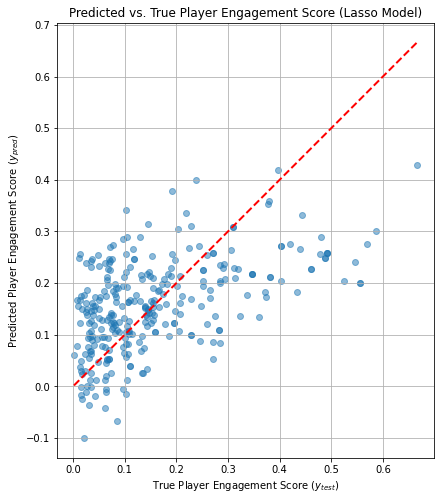

In [140]:
# Identify the best model's predictions (Lasso in this case)
best_model_pred = y_lasso_pred 

plt.figure(figsize=(8, 8))
plt.scatter(y_test, best_model_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2) # y=x line
plt.title('Predicted vs. True Player Engagement Score (Lasso Model)')
plt.xlabel('True Player Engagement Score ($y_{test}$)')
plt.ylabel('Predicted Player Engagement Score ($y_{pred}$)')
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

#### 2. Coefficient Magnitude Comparison Plot
We compare the top 10 most influential coefficients across the Baseline, Ridge, and Lasso models to visually demonstrate the effect of regularization .

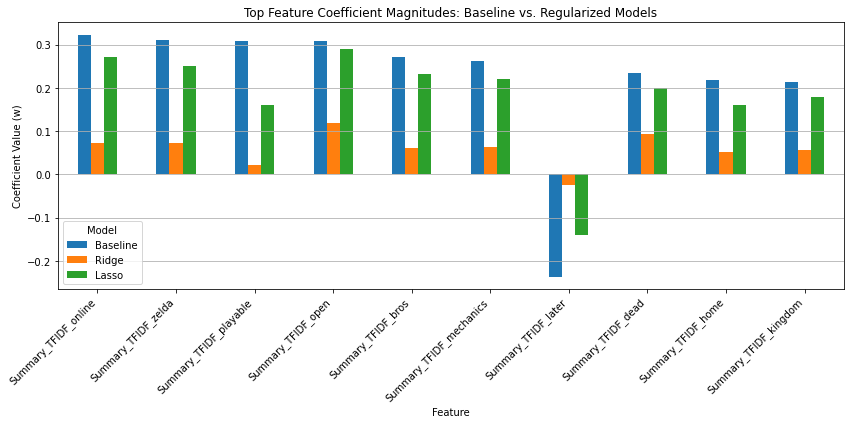

In [141]:
def plot_top_n_coefficients(models, feature_names, n=10):
    # Get all coefficients
    coefs_df = pd.DataFrame({
        'Feature': feature_names,
        'Baseline': models['Baseline (MLR)'].coef_,
        'Ridge': models['Ridge ($L_2$)'].coef_,
        'Lasso': models['Lasso ($L_1$)'].coef_
    })
    
    # Find the top N features based on absolute magnitude from the Lasso model (best for feature selection)
    coefs_df['Max_Magnitude'] = coefs_df[['Baseline', 'Ridge', 'Lasso']].abs().max(axis=1)
    top_features = coefs_df.nlargest(n, 'Max_Magnitude')
    
    top_features.set_index('Feature')[['Baseline', 'Ridge', 'Lasso']].plot(kind='bar', figsize=(12, 6))
    plt.title('Top Feature Coefficient Magnitudes: Baseline vs. Regularized Models')
    plt.ylabel('Coefficient Value (w)')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Model')
    plt.tight_layout()
    plt.grid(axis='y')
    plt.show()

# Create a dictionary of fitted models
fitted_models = {
    'Baseline (MLR)': baseline_model,
    'Ridge ($L_2$)': best_ridge,
    'Lasso ($L_1$)': best_lasso
}

plot_top_n_coefficients(fitted_models, feature_names, n=10)

## Conclusion
* Key Findings: Discuss the MAE and R^2 improvement from the Baseline model to the regularized models. (e.g., Lasso provides the best overall MAE, demonstrating the benefit of L1 feature selection on a high-dimensional dataset).

* Model Choice: Explain why the Lasso model was the final choice (lowest MAE/RMSE).

* Insights: Use the coefficient plot to discuss which features (e.g., 'Rating', specific TF-IDF keywords, or genres) are most predictive of player engagement.

* Learnings: Summarize what you learned about data preparation (e.g., the necessity of standardization for regularization) and experimental design (e.g., using cross-validation for hyperparameter tuning).

## Team Contributions
* **Michael Alva:**
* **Cameron Matthews:**